In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import pandas as pd
import numpy as np
df_location = '/content/drive/MyDrive/Weather/41.9N_12.46E.csv'
df = pd.read_csv(df_location)
df.columns = ['year', 'month', 'day', 'hour', 'temperature', 'precipitation', 'u-wind', 'v-wind']
df.temperature = df.temperature -273.15

In [11]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df['wind'] = (df['u-wind']**2 + df['v-wind']**2)**0.5
# Constants for transformations
hours_in_day = 24
days_in_month = 30  #approdf
months_in_year = 12

# Add cyclical hour features
df['hour_sin'] = np.sin(2 * np.pi * df['date'].dt.hour / hours_in_day)

# Add cyclical day features
df['day_sin'] = np.sin(2 * np.pi * df['date'].dt.day / days_in_month)

# Add cyclical month features
df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / months_in_year)

columns_to_drop = ['month','day','hour']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)
df

,year,temperature,precipitation,u-wind,v-wind,date,wind,hour_sin,day_sin,month_sin
0,1980,10.92,1.771900e-05,5.0144,-8.4435,1980-01-01 01:00:00,9.820229,0.258819,0.207912,5.000000e-01
1,1980,11.01,1.958600e-05,4.9712,-7.7456,1980-01-01 02:00:00,9.203649,0.500000,0.207912,5.000000e-01
2,1980,11.05,9.337800e-07,4.5916,-7.5101,1980-01-01 03:00:00,8.802522,0.707107,0.207912,5.000000e-01
3,1980,10.99,1.958600e-05,4.4404,-7.1360,1980-01-01 04:00:00,8.404740,0.866025,0.207912,5.000000e-01
4,1980,10.93,5.875300e-05,4.6318,-6.5412,1980-01-01 05:00:00,8.015040,0.965926,0.207912,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...
341874,2018,14.18,0.000000e+00,-1.3146,-3.9372,2018-12-31 19:00:00,4.150869,-0.965926,0.207912,-2.449294e-16
341875,2018,13.80,0.000000e+00,-2.1201,-4.0275,2018-12-31 20:00:00,4.551437,-0.866025,0.207912,-2.449294e-16
341876,2018,13.30,0.000000e+00,-2.7930,-4.4435,2018-12-31 21:00:00,5.248385,-0.707107,0.207912,-2.449294e-16
341877,2018,13.28,0.000000e+00,-3.0675,-5.7936,2018-12-31 22:00:00,6.555559,-0.500000,0.207912,-2.449294e-16


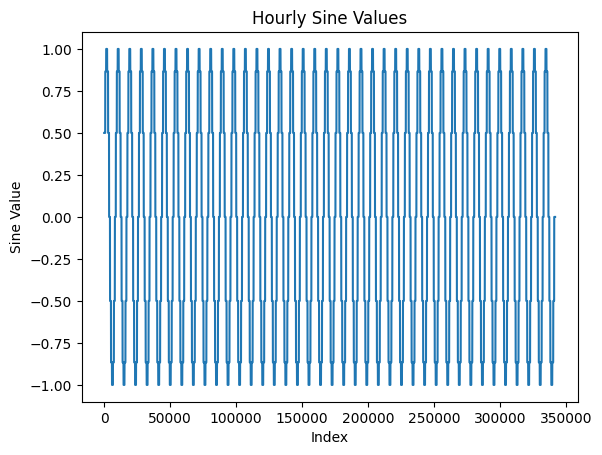

In [12]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it contains a column named 'hour_sin'
plt.plot(df['month_sin'],)
plt.title('Hourly Sine Values')
plt.xlabel('Index')
plt.ylabel('Sine Value')
plt.show()


In [13]:
df.isnull().sum()

year             0
temperature      0
precipitation    0
u-wind           0
v-wind           0
date             0
wind             0
hour_sin         0
day_sin          0
month_sin        0
dtype: int64

In [14]:
df_filtered = df.tail(4*7 * 24)
train_data = df_filtered.iloc[:-24]  # First 7 days
test_data = df_filtered.iloc[-24:]  # Last day

In [15]:
training_set = df_filtered['temperature'].values

In [16]:
def df_to_XY(df,window_size=10):
 X_train=[]
 y_train=[]

 for i in range(10,len(training_set)):
    X_train.append(training_set[i-10:i])
    y_train.append(training_set[i])

 X_train, y_train = np.array(X_train), np.array(y_train)
 return X_train, y_train

WINDOW = 10
X,y = df_to_XY(df_filtered,WINDOW)
print(len(X),len(y))


X_train = X[:-48]
y_train = y[:-48]
X_val = X[-48:-24]
y_val = y[-48:-24]
X_test = X[-24:]
y_test = y[-24:]




662 662


In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

regressor = Sequential()

# Adjusting LSTM layers
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=100))
regressor.add(Dropout(0.2))

# Output layer
regressor.add(Dense(units=1))

# Optimizer with adjustable learning rate
optimizer = Adam(learning_rate=0.001)

regressor.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = regressor.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=16, callbacks=[early_stopping])


Epoch 1/100
39/39 [==============================] - 10s 38ms/step - loss: 38.1124 - val_loss: 0.9364
Epoch 2/100
39/39 [==============================] - 0s 8ms/step - loss: 6.3640 - val_loss: 0.4007
Epoch 3/100
39/39 [==============================] - 0s 8ms/step - loss: 5.9105 - val_loss: 0.3977
Epoch 4/100
39/39 [==============================] - 0s 9ms/step - loss: 6.2494 - val_loss: 0.4010
Epoch 5/100
39/39 [==============================] - 0s 9ms/step - loss: 5.9846 - val_loss: 0.3951
Epoch 6/100
39/39 [==============================] - 0s 8ms/step - loss: 6.2736 - val_loss: 0.4369
Epoch 7/100
39/39 [==============================] - 0s 8ms/step - loss: 5.8757 - val_loss: 0.4226
Epoch 8/100
39/39 [==============================] - 0s 9ms/step - loss: 4.6982 - val_loss: 0.5440
Epoch 9/100
39/39 [==============================] - 0s 8ms/step - loss: 2.8905 - val_loss: 0.7149
Epoch 10/100
39/39 [==============================] - 0s 8ms/step - loss: 1.7817 - val_loss: 0.6230
Epoch 

In [18]:
his = pd.DataFrame(history.history)
his.head()


,loss,val_loss
0,38.112392,0.936374
1,6.363962,0.400665
2,5.910459,0.397742
3,6.249364,0.400956
4,5.984552,0.395139


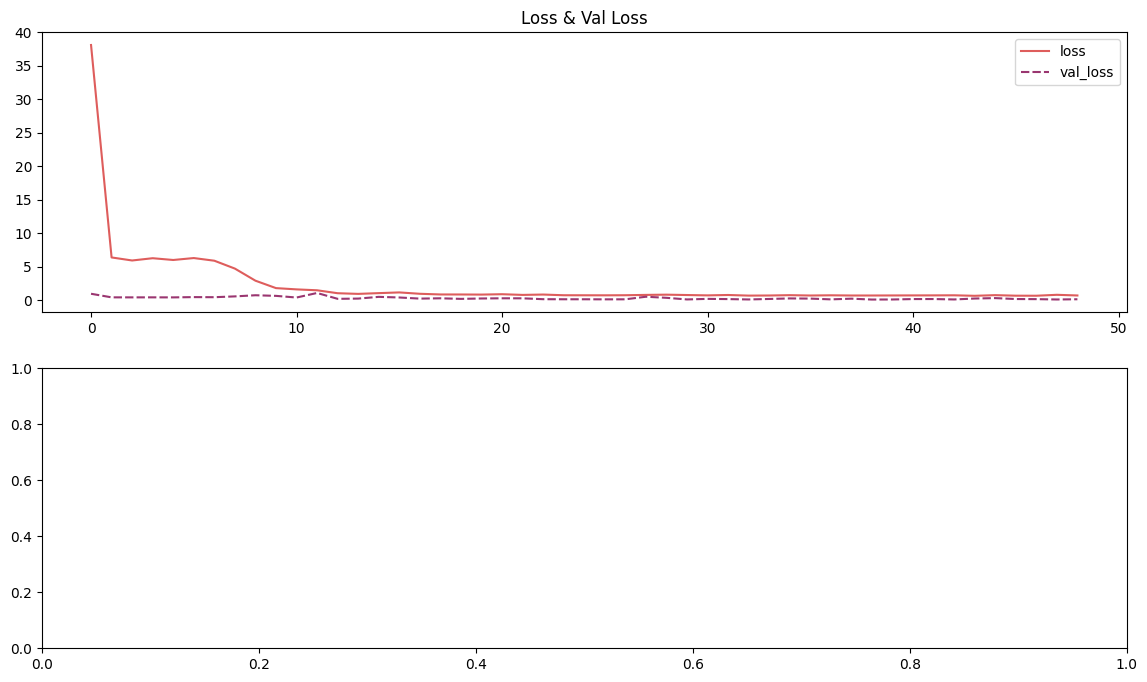

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

his.columns
history_loss = his[['loss', 'val_loss']]


fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.title("Loss & Val Loss")
sns.lineplot(history_loss,palette="flare");

In [20]:
train_pred = regressor.predict(X_train).flatten()
val_pred = regressor.predict(X_val).flatten()
test_pred = regressor.predict(X_test).flatten()

1/1 [==============================] - 0s 24ms/step


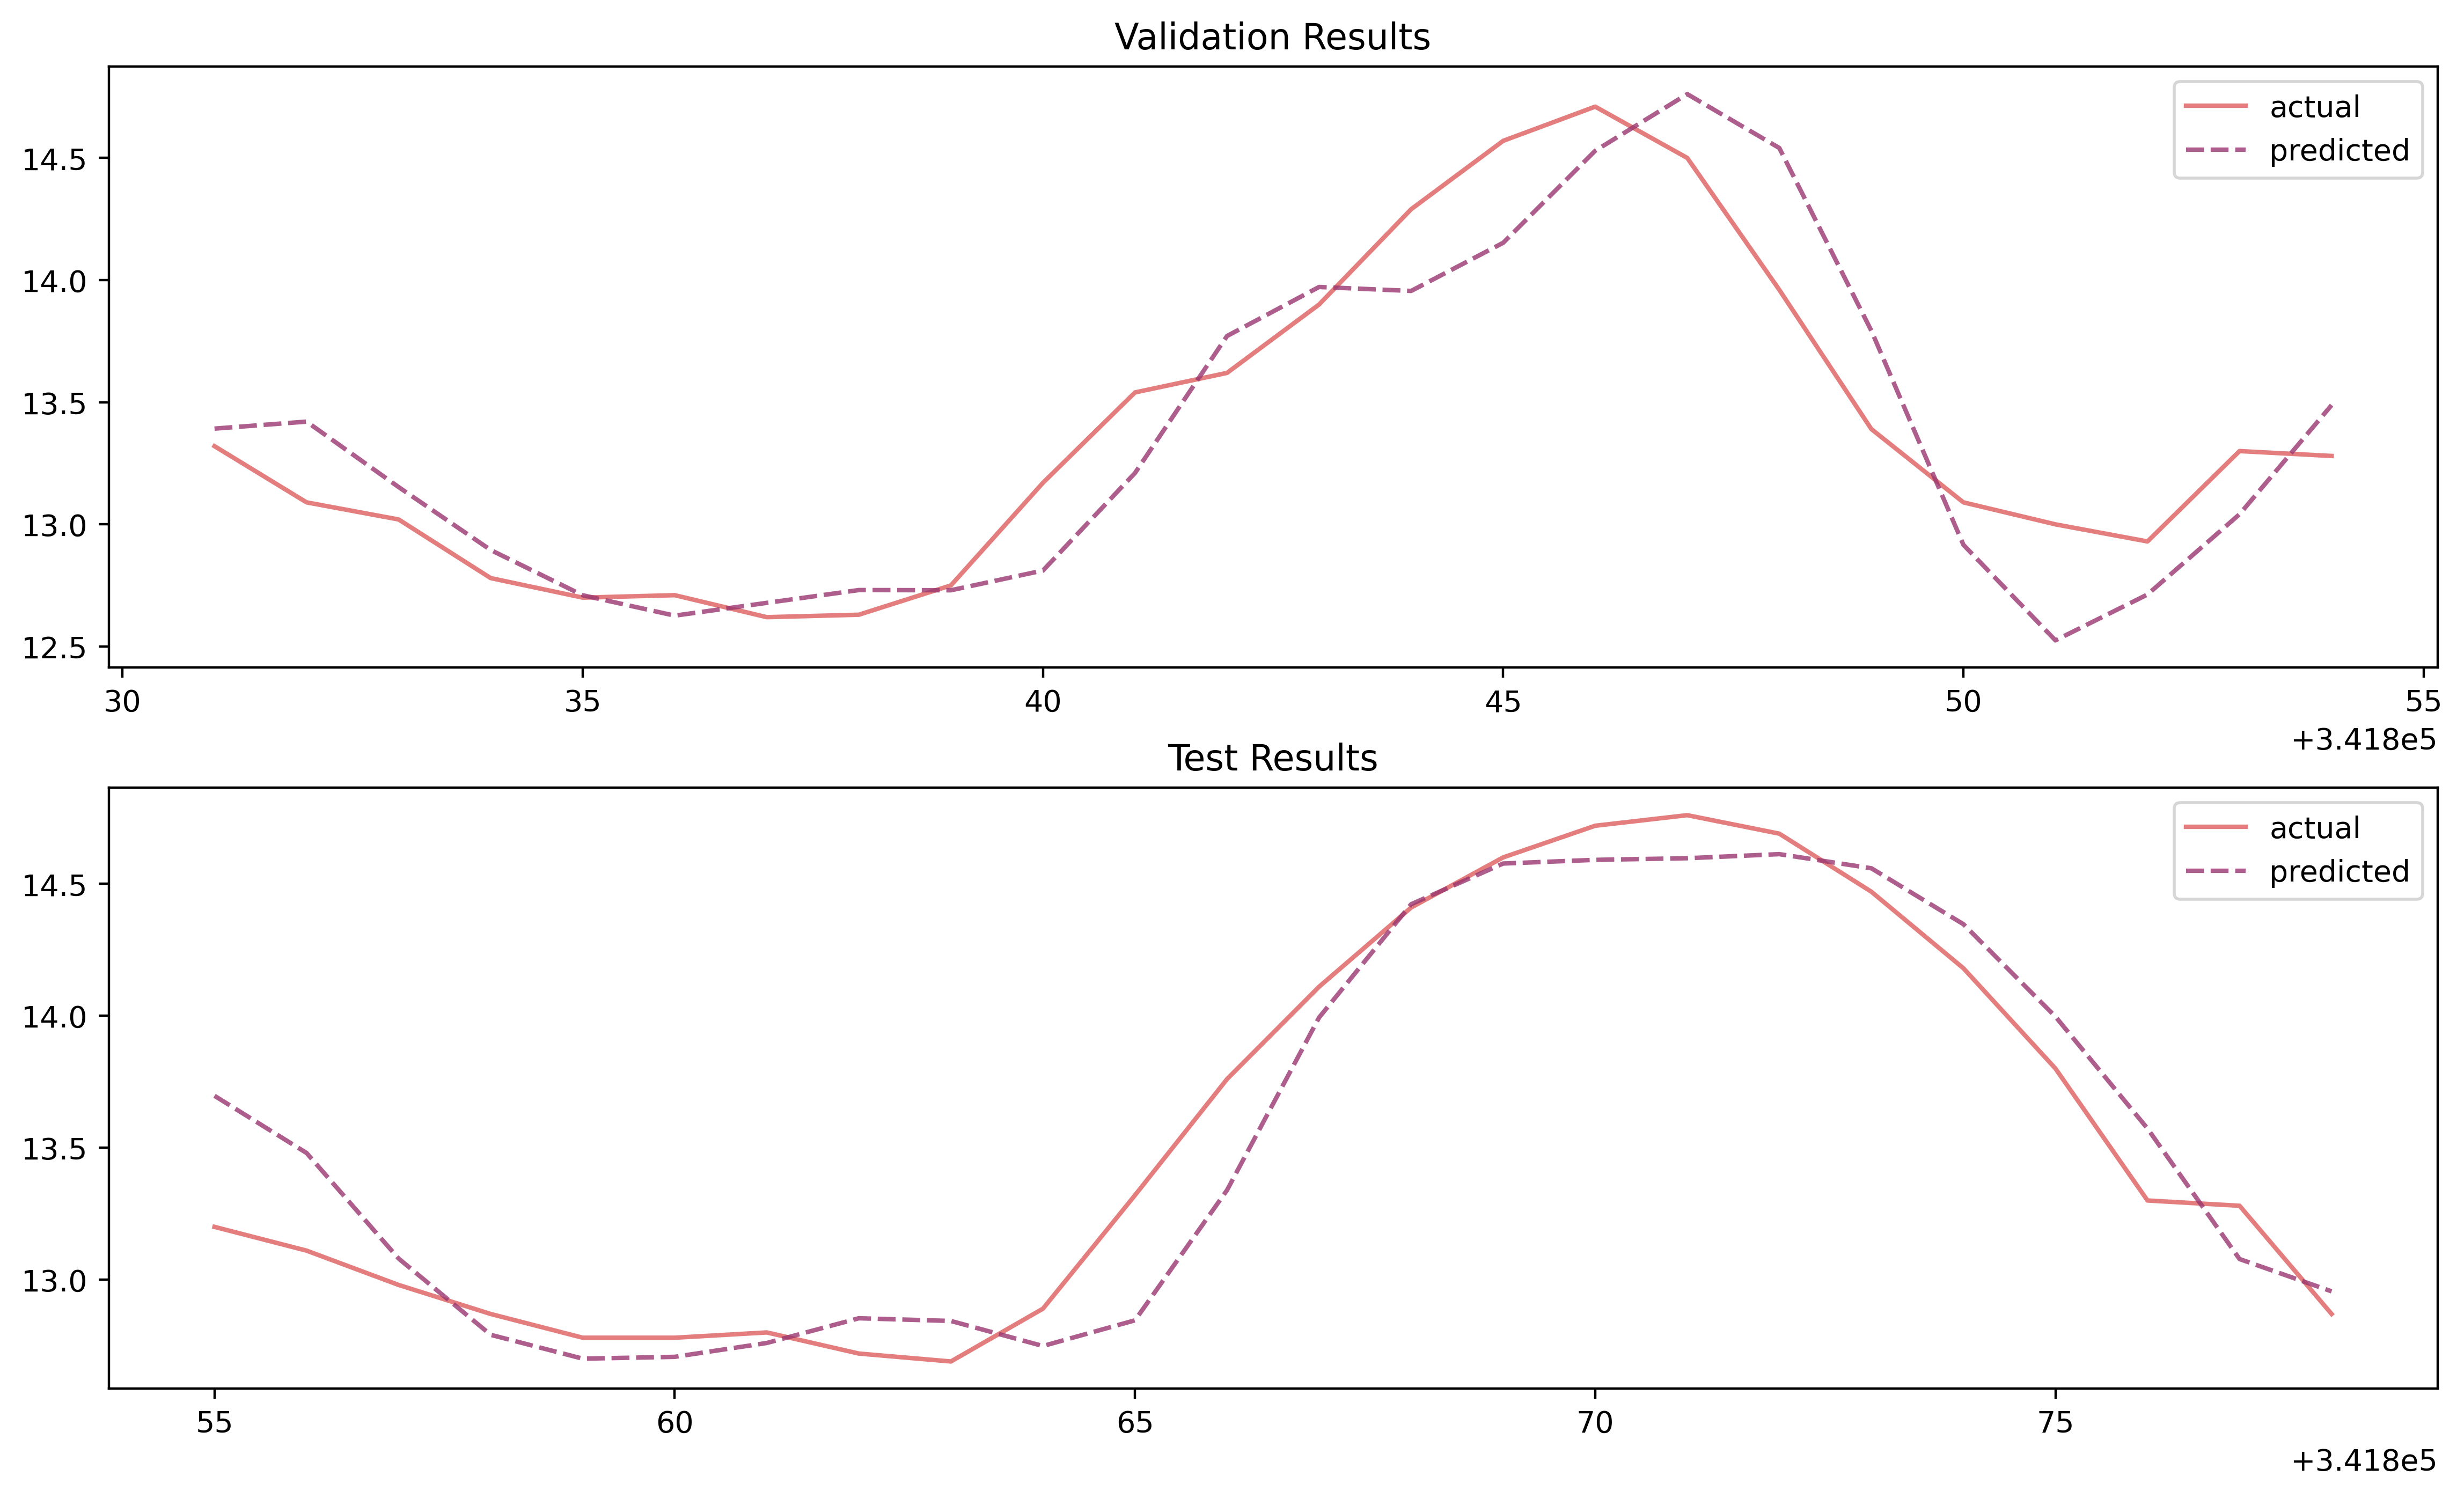

In [21]:
pred = np.concatenate([train_pred,val_pred,test_pred])
df_pred = pd.DataFrame(df_filtered["temperature"].copy())
df_pred.columns=["actual"]
df_pred = df_pred[WINDOW:]
df_pred["predicted"] = pred

fig,axes = plt.subplots(2,1,figsize=(14,8),dpi=400)

plt.subplot(2,1,1)
plt.title("Validation Results")
sns.lineplot(df_pred[-48:-24],alpha=0.8,palette="flare",linestyle=None);

plt.subplot(2,1,2)
plt.title("Test Results")
sns.lineplot(df_pred[-24:],alpha=0.8,palette="flare",linestyle=None);

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/100
525/525 [==============================] - 13s 9ms/step - loss: 30.9905 - val_loss: 1.4593
Epoch 2/100
525/525 [==============================] - 4s 7ms/step - loss: 2.0107 - val_loss: 0.2698
Epoch 3/100
525/525 [==============================] - 8s 15ms/step - loss: 1.4327 - val_loss: 0.1556
Epoch 4/100
525/525 [==============================] - 5s 9ms/step - loss: 1.4049 - val_loss: 0.1627
Epoch 5/100
525/525 [==============================] - 5s 9ms/step - loss: 1.3274 - val_loss: 0.2531
Epoch 6/100
525/525 [==============================] - 4s 7ms/step - loss: 1.2457 - val_loss: 0.2923
Epoch 7/100
525/525 [==============================] - 4s 7ms/step - loss: 1.2169 - val_loss: 0.0487
Epoch 8/100
525/525 [==============================] - 4s 8ms/step - loss: 1.2254 - val_loss: 0.0707
Epoch 9/100
525/525 [==============================] - 4s 8m

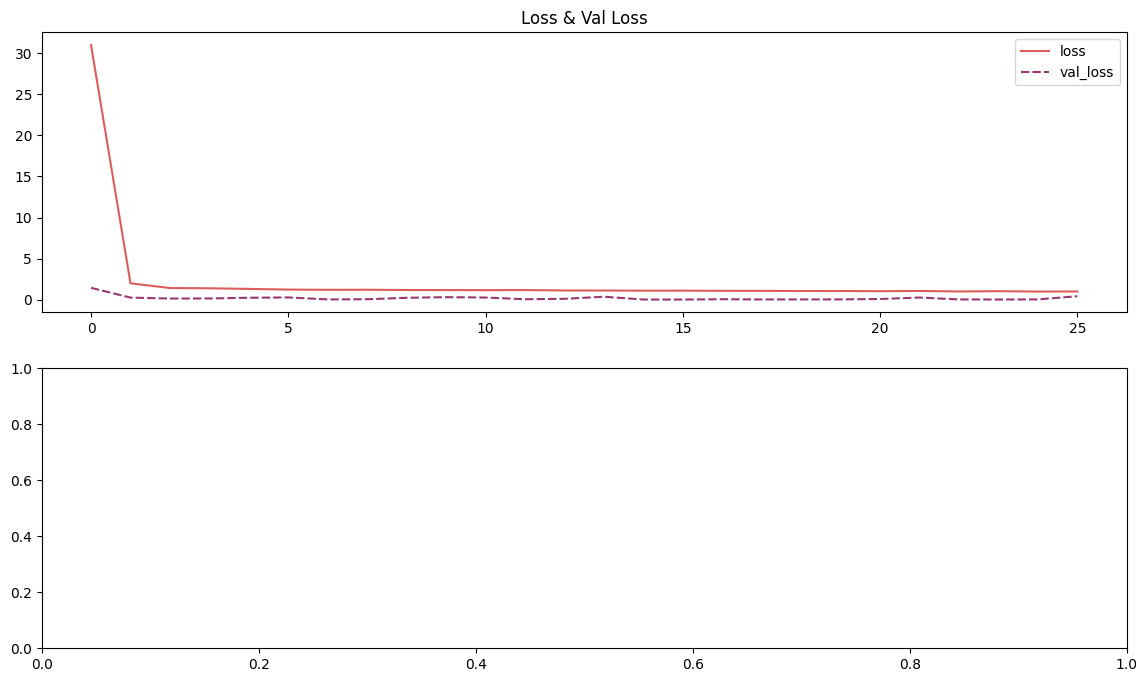

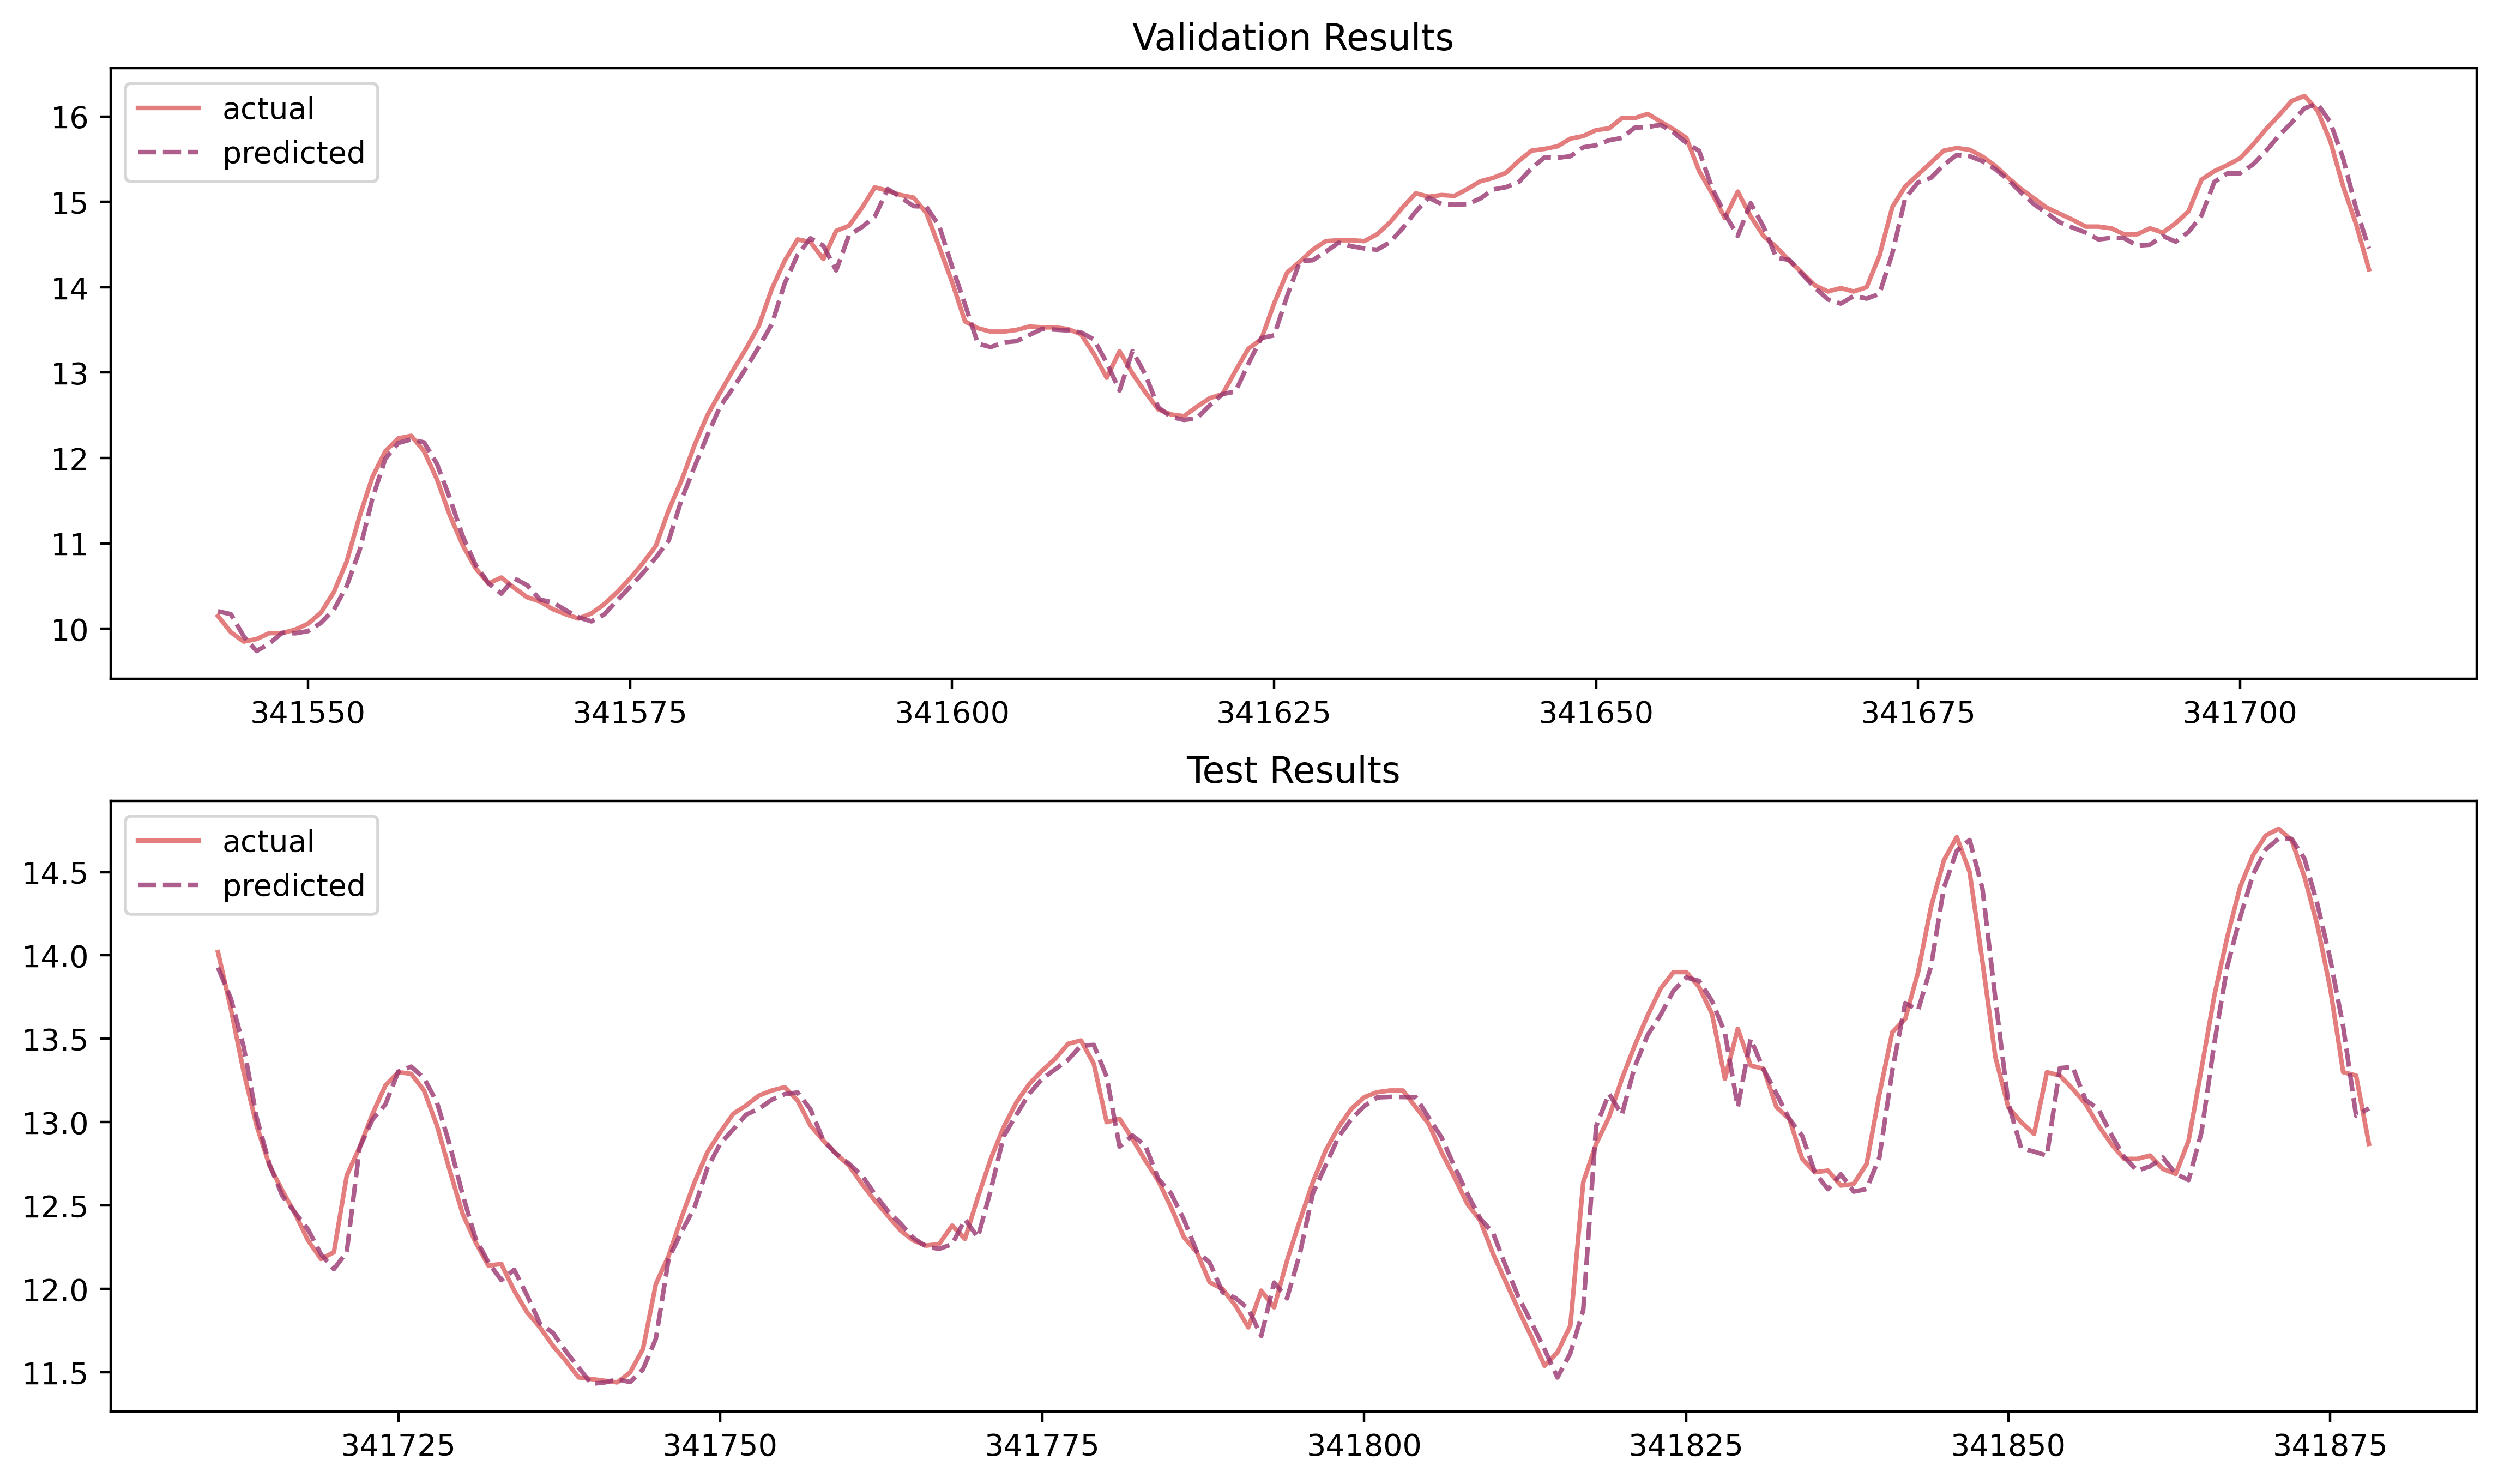

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


drive.mount('/content/drive')

df_location = '/content/drive/MyDrive/Weather/41.9N_12.46E.csv'
df = pd.read_csv(df_location)
df.columns = ['year', 'month', 'day', 'hour', 'temperature', 'precipitation', 'u-wind', 'v-wind']
df.temperature = df.temperature -273.15

df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df['wind'] = (df['u-wind']**2 + df['v-wind']**2)**0.5
# Constants for transformations
hours_in_day = 24
days_in_month = 30  #approdf
months_in_year = 12

# Add cyclical hour features
df['hour_sin'] = np.sin(2 * np.pi * df['date'].dt.hour / hours_in_day)
df['hour_cos'] = np.cos(2 * np.pi * df['date'].dt.hour / hours_in_day)

# Add cyclical day features
df['day_sin'] = np.sin(2 * np.pi * df['date'].dt.day / days_in_month)
df['day_cos'] = np.cos(2 * np.pi * df['date'].dt.day / days_in_month)

# Add cyclical month features
df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / months_in_year)
df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month / months_in_year)

columns_to_drop = ['year','month','day','hour']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)
df.isnull().sum()

df_filtered = df.tail(52*7 * 24)
train_data = df_filtered.iloc[:-24]  # First 7 days
test_data = df_filtered.iloc[-24:]  # Last day

training_set = df_filtered['temperature'].values

def df_to_XY(df,window_size=10):
 X_train=[]
 y_train=[]

 for i in range(10,len(training_set)):
    X_train.append(training_set[i-10:i])
    y_train.append(training_set[i])

 X_train, y_train = np.array(X_train), np.array(y_train)
 return X_train, y_train

WINDOW = 10
X,y = df_to_XY(df_filtered,WINDOW)

X_train = X[:-24*7*2]
y_train = y[:-24*7*2]
X_val = X[-24*7*2:-24*7]
y_val = y[-24*7*2:-24*7]
X_test = X[-24*7:]
y_test = y[-24*7:]

regressor = Sequential()

# Adjusting LSTM layers
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=100))
regressor.add(Dropout(0.2))

# Output layer
regressor.add(Dense(units=1))

# Optimizer with adjustable learning rate
#optimizer = Adam(learning_rate=0.001)
optimizer = Adam(learning_rate=0.001)

regressor.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = regressor.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=16, callbacks=[early_stopping])

his = pd.DataFrame(history.history)
his.head()

his.columns
history_loss = his[['loss', 'val_loss']]

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.title("Loss & Val Loss")
sns.lineplot(history_loss,palette="flare");

train_pred = regressor.predict(X_train).flatten()
val_pred = regressor.predict(X_val).flatten()
test_pred = regressor.predict(X_test).flatten()

pred = np.concatenate([train_pred,val_pred,test_pred])
df_pred = pd.DataFrame(df_filtered["temperature"].copy())
df_pred.columns=["actual"]
df_pred = df_pred[WINDOW:]
df_pred["predicted"] = pred

fig,axes = plt.subplots(2,1,figsize=(14,8),dpi=400)

plt.subplot(2,1,1)
plt.title("Validation Results")
sns.lineplot(df_pred[-24*7*2:-24*7],alpha=0.8,palette="flare",linestyle=None);

plt.subplot(2,1,2)
plt.title("Test Results")
sns.lineplot(df_pred[-24*7:],alpha=0.8,palette="flare",linestyle=None);
















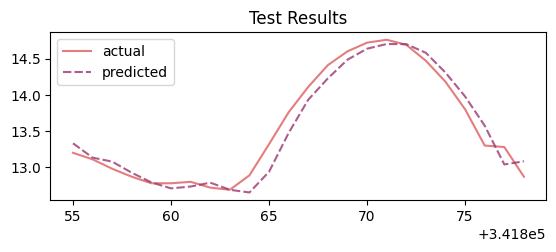

In [ ]:
plt.subplot(2,1,2)
plt.title("Test Results")
sns.lineplot(df_pred[-24:],alpha=0.8,palette="flare",linestyle=None);

In [ ]:
df_pred

,actual,predicted
333153,12.50,13.170853
333154,12.75,12.358650
333155,13.13,12.620038
333156,13.65,13.301229
333157,13.93,13.792896
...,...,...
341874,14.18,14.306582
341875,13.80,13.977027
341876,13.30,13.574224
341877,13.28,13.039536


In [ ]:
test_pred

array([13.92724  , 13.741588 , 13.450481 , 13.028052 , 12.748326 ,
       12.558073 , 12.45672  , 12.356024 , 12.20794  , 12.118482 ,
       12.221757 , 12.848682 , 13.016432 , 13.107073 , 13.303163 ,
       13.333278 , 13.263846 , 13.118575 , 12.863356 , 12.565322 ,
       12.303119 , 12.159064 , 12.053096 , 12.11528  , 11.961918 ,
       11.792945 , 11.737711 , 11.627132 , 11.528604 , 11.431391 ,
       11.439213 , 11.458441 , 11.441894 , 11.518982 , 11.701429 ,
       12.184846 , 12.3422785, 12.489893 , 12.7249975, 12.871999 ,
       12.956261 , 13.044915 , 13.080685 , 13.134852 , 13.168191 ,
       13.178007 , 13.077639 , 12.891834 , 12.810151 , 12.750883 ,
       12.680335 , 12.569161 , 12.468027 , 12.391401 , 12.305246 ,
       12.253267 , 12.240548 , 12.268578 , 12.416736 , 12.309529 ,
       12.592102 , 12.914525 , 13.045686 , 13.172157 , 13.260593 ,
       13.316819 , 13.373372 , 13.458715 , 13.463486 , 13.271299 ,
       12.853668 , 12.920541 , 12.859447 , 12.661653 , 12.5727

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/100
543/543 [==============================] - 11s 9ms/step - loss: 12.9059 - val_loss: 0.3957
Epoch 2/100
543/543 [==============================] - 4s 7ms/step - loss: 1.8846 - val_loss: 0.4626
Epoch 3/100
543/543 [==============================] - 5s 9ms/step - loss: 1.5725 - val_loss: 0.2370
Epoch 4/100
543/543 [==============================] - 4s 7ms/step - loss: 1.4472 - val_loss: 0.2122
Epoch 5/100
543/543 [==============================] - 4s 7ms/step - loss: 1.3839 - val_loss: 0.1943
Epoch 6/100
543/543 [==============================] - 5s 9ms/step - loss: 1.4566 - val_loss: 0.2019
Epoch 7/100
543/543 [==============================] - 4s 8ms/step - loss: 1.2740 - val_loss: 0.1825
Epoch 8/100
543/543 [==============================] - 4s 8ms/step - loss: 1.3115 - val_loss: 0.1896
Epoch 9/100
543/543 [==============================] - 5s 9ms

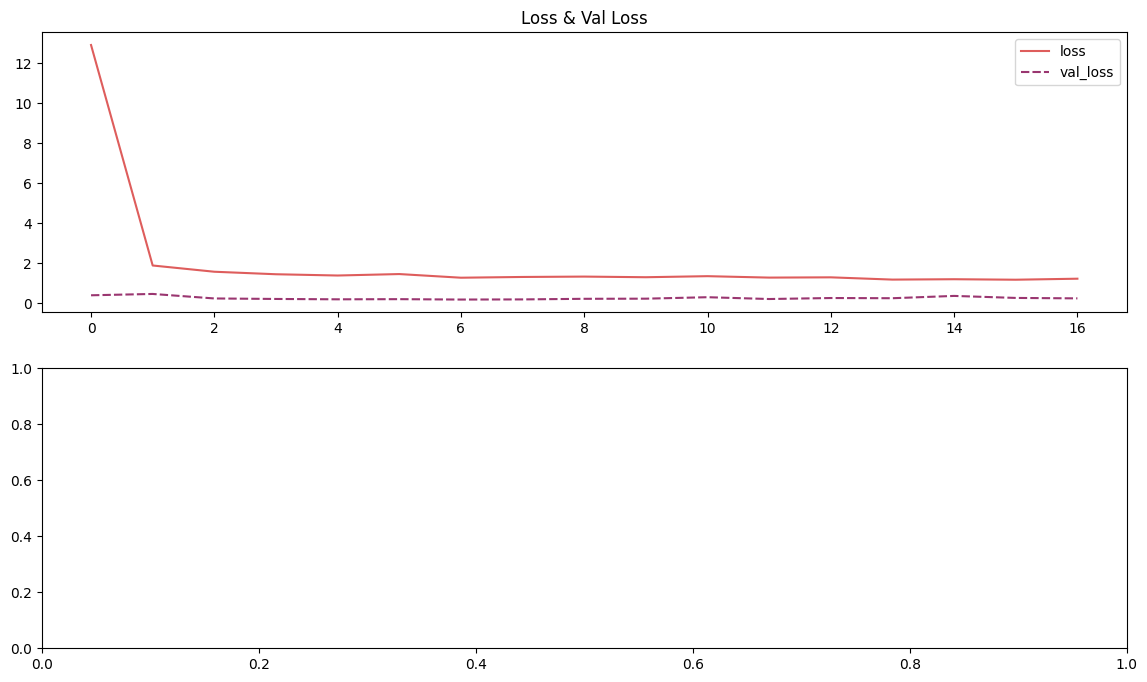

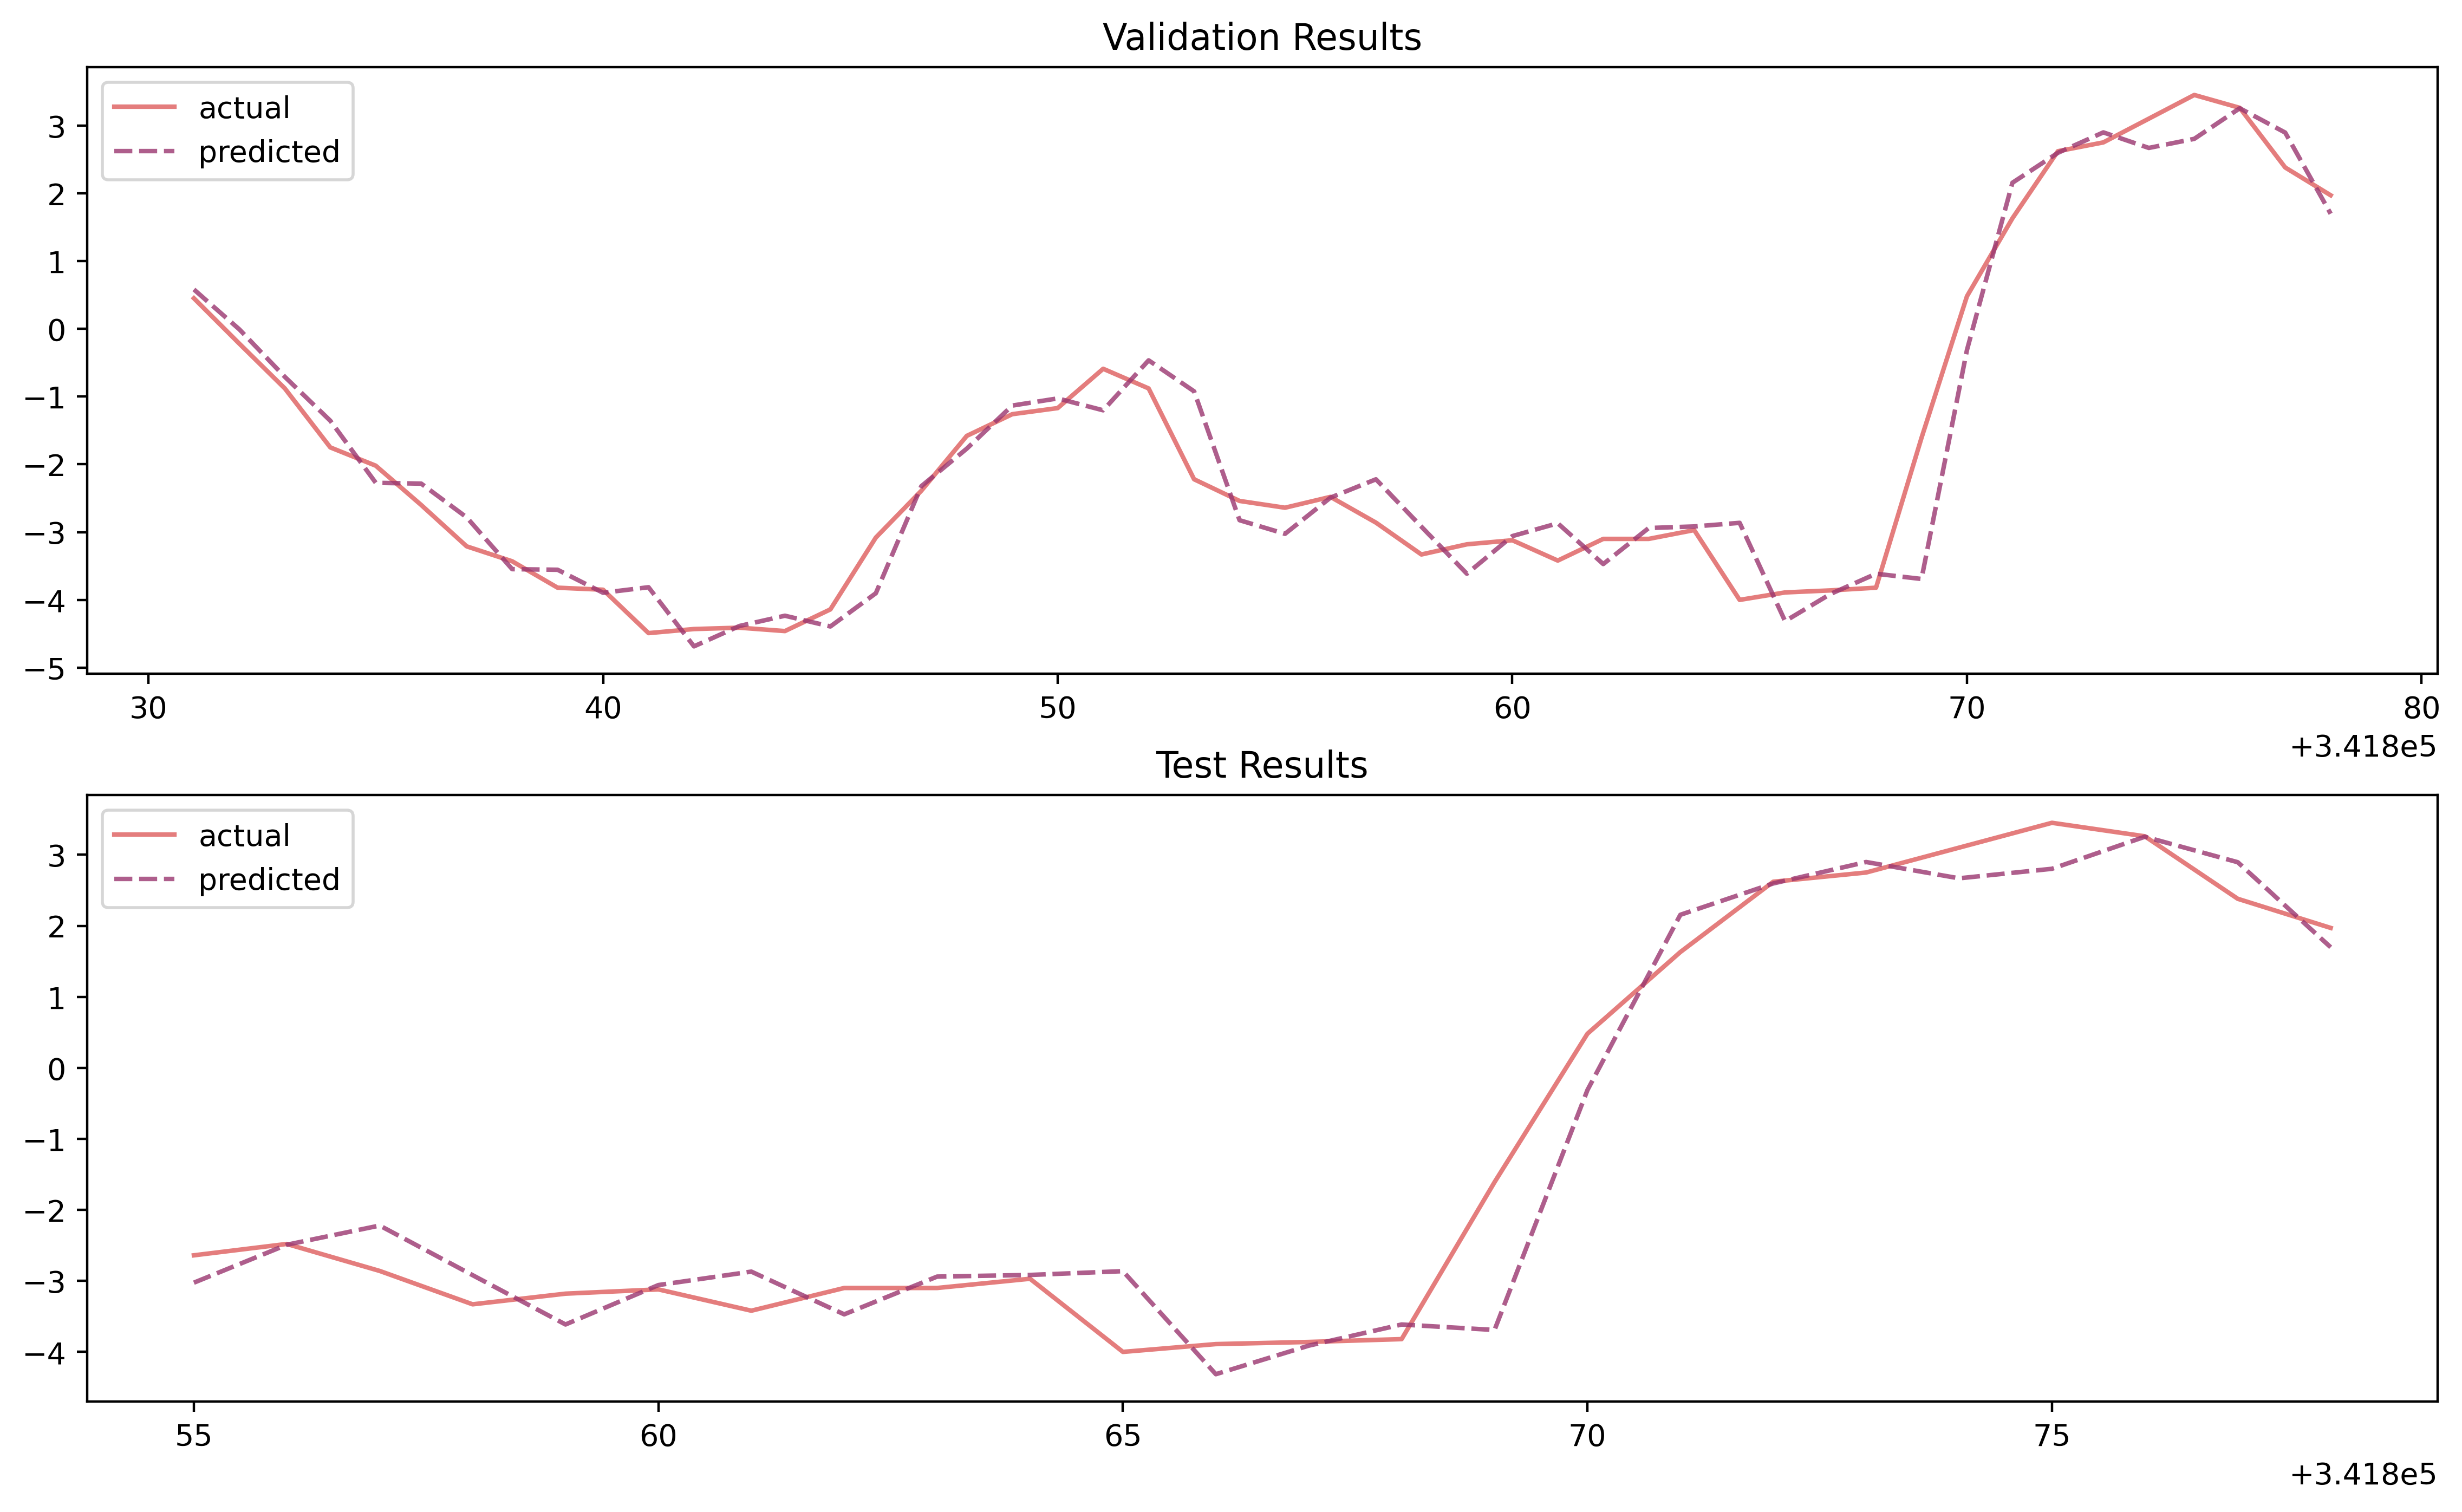

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


drive.mount('/content/drive')

df_location = '/content/drive/MyDrive/Weather/40.75N_286.01E.csv'
df = pd.read_csv(df_location)
df.columns = ['year', 'month', 'day', 'hour', 'temperature', 'precipitation', 'u-wind', 'v-wind']
df.temperature = df.temperature -273.15

df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df['wind'] = (df['u-wind']**2 + df['v-wind']**2)**0.5
# Constants for transformations
hours_in_day = 24
days_in_month = 30  #approdf
months_in_year = 12

# Add cyclical hour features
df['hour_sin'] = np.sin(2 * np.pi * df['date'].dt.hour / hours_in_day)
df['hour_cos'] = np.cos(2 * np.pi * df['date'].dt.hour / hours_in_day)

# Add cyclical day features
df['day_sin'] = np.sin(2 * np.pi * df['date'].dt.day / days_in_month)
df['day_cos'] = np.cos(2 * np.pi * df['date'].dt.day / days_in_month)

# Add cyclical month features
df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / months_in_year)
df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month / months_in_year)

columns_to_drop = ['year','month','day','hour']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)


df.isnull().sum()

df_filtered = df.tail(52*7 * 24)
train_data = df_filtered.iloc[:-24]  # First 7 days
test_data = df_filtered.iloc[-24:]  # Last day

training_set = df_filtered['temperature'].values


def df_to_XY(df,window_size=10):
 X_train=[]
 y_train=[]

 for i in range(10,len(training_set)):
    X_train.append(training_set[i-10:i])
    y_train.append(training_set[i])

 X_train, y_train = np.array(X_train), np.array(y_train)
 return X_train, y_train


WINDOW = 10
X,y = df_to_XY(df_filtered,WINDOW)


X_train = X[:-48]
y_train = y[:-48]
X_val = X[-48:-24]
y_val = y[-48:-24]
X_test = X[-24:]
y_test = y[-24:]

regressor = Sequential()

# Adjusting LSTM layers
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=100))
regressor.add(Dropout(0.2))

# Output layer
regressor.add(Dense(units=1))

# Optimizer with adjustable learning rate
optimizer = Adam(learning_rate=0.001)

regressor.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = regressor.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=16, callbacks=[early_stopping])

his = pd.DataFrame(history.history)
his.head()

his.columns
history_loss = his[['loss', 'val_loss']]

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.title("Loss & Val Loss")
sns.lineplot(history_loss,palette="flare");

train_pred = regressor.predict(X_train).flatten()
val_pred = regressor.predict(X_val).flatten()
test_pred = regressor.predict(X_test).flatten()

pred = np.concatenate([train_pred,val_pred,test_pred])
df_pred = pd.DataFrame(df_filtered["temperature"].copy())
df_pred.columns=["actual"]
df_pred = df_pred[WINDOW:]
df_pred["predicted"] = pred

fig,axes = plt.subplots(2,1,figsize=(14,8),dpi=400)

plt.subplot(2,1,1)
plt.title("Validation Results")
sns.lineplot(df_pred[-48:],alpha=0.8,palette="flare",linestyle=None);

plt.subplot(2,1,2)
plt.title("Test Results")
sns.lineplot(df_pred[-24:],alpha=0.8,palette="flare",linestyle=None);



# Metrics
mae = mean_absolute_error(y_test, test_pred)
mse = mean_squared_error(y_test, test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, test_pred)





In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def train_and_evaluate_rnn(window_size):
    X, y = df_to_XY(df_filtered, window_size)

    # Train-test split
    X_train = X[:-48]
    y_train = y[:-48]
    X_val = X[-48:-24]
    y_val = y[-48:-24]
    X_test = X[-24:]
    y_test = y[-24:]

    # RNN model definition
    regressor = Sequential()
    regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=100, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=100))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units=1))

    optimizer = Adam(learning_rate=0.001)
    regressor.compile(optimizer=optimizer, loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    regressor.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=16, callbacks=[early_stopping])

    # Predictions
    y_pred_test = regressor.predict(X_test).flatten()

    # Metrics
    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_test)

    return mae, mse, rmse, r2

# Loop over different window sizes
window_sizes = [1,2,3,5,10,15,20,25,30]  # Example window sizes
results = []

for window in window_sizes:
    mae, mse, rmse, r2 = train_and_evaluate_rnn(window)
    results.append({'Window Size': window, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2 Score': r2})

# Convert results to a DataFrame for easier viewing
results_df = pd.DataFrame(results)
print(results_df)


NameError: name 'df_to_XY' is not defined

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


drive.mount('/content/drive')

df_location = '/content/drive/MyDrive/Weather/41.9N_12.46E.csv'
df = pd.read_csv(df_location)
df.columns = ['year', 'month', 'day', 'hour', 'temperature', 'precipitation', 'u-wind', 'v-wind']
df.temperature = df.temperature -273.15

df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df['wind'] = (df['u-wind']**2 + df['v-wind']**2)**0.5
# Constants for transformations
hours_in_day = 24
days_in_month = 30  #approdf
months_in_year = 12

# Add cyclical hour features
df['hour_sin'] = np.sin(2 * np.pi * df['date'].dt.hour / hours_in_day)
df['hour_cos'] = np.cos(2 * np.pi * df['date'].dt.hour / hours_in_day)

# Add cyclical day features
df['day_sin'] = np.sin(2 * np.pi * df['date'].dt.day / days_in_month)
df['day_cos'] = np.cos(2 * np.pi * df['date'].dt.day / days_in_month)

# Add cyclical month features
df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / months_in_year)
df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month / months_in_year)

columns_to_drop = ['year','month','day','hour']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)

df.isnull().sum()

df_filtered = df.tail(4*7 * 24)
train_data = df_filtered.iloc[:-24]  # First 7 days
test_data = df_filtered.iloc[-24:]  # Last day

training_set = df_filtered['temperature'].values

def df_to_XY(df,window_size=10):
 X_train=[]
 y_train=[]

 for i in range(10,len(training_set)):
    X_train.append(training_set[i-10:i])
    y_train.append(training_set[i])

 X_train, y_train = np.array(X_train), np.array(y_train)
 return X_train, y_train




WINDOW = 10
X,y = df_to_XY(df_filtered,WINDOW)

X_train = X[:-48]
y_train = y[:-48]
X_val = X[-48:-24]
y_val = y[-48:-24]
X_test = X[-24:]
y_test = y[-24:]

regressor = Sequential()

# Adjusting LSTM layers
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=100))
regressor.add(Dropout(0.2))

# Output layer
regressor.add(Dense(units=1))

# Optimizer with adjustable learning rate
optimizer = Adam(learning_rate=0.001)

regressor.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = regressor.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=16, callbacks=[early_stopping])

his = pd.DataFrame(history.history)
his.head()

his.columns
history_loss = his[['loss', 'val_loss']]

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.title("Loss & Val Loss")
sns.lineplot(history_loss,palette="flare");

train_pred = regressor.predict(X_train).flatten()
val_pred = regressor.predict(X_val).flatten()
test_pred = regressor.predict(X_test).flatten()

pred = np.concatenate([train_pred,val_pred,test_pred])
df_pred = pd.DataFrame(df_filtered["temperature"].copy())
df_pred.columns=["actual"]
df_pred = df_pred[WINDOW:]
df_pred["predicted"] = pred

fig,axes = plt.subplots(2,1,figsize=(14,8),dpi=400)

plt.subplot(2,1,1)
plt.title("Validation Results")
sns.lineplot(df_pred[-48:],alpha=0.8,palette="flare",linestyle=None);

plt.subplot(2,1,2)
plt.title("Test Results")
sns.lineplot(df_pred[-24:],alpha=0.8,palette="flare",linestyle=None);



df_pred

print(mean_absolute_error(y_test, y_pred_xg))
print(mean_squared_error(y_test, y_pred_xg))
print(np.sqrt(mean_squared_error(y_test, y_pred_xg)))
np.mean(abs_percentage_errors),
'R2': r2_xg













SyntaxError: illegal target for annotation (<ipython-input-2-d0584d1f8b81>, line 139)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def train_and_evaluate_rnn(batch_size):
    WINDOW_SIZE = 10  # Set your window size
    X, y = df_to_XY(df_filtered, WINDOW_SIZE)

    # Train-test split
    X_train = X[:-48]
    y_train = y[:-48]
    X_val = X[-48:-24]
    y_val = y[-48:-24]
    X_test = X[-24:]
    y_test = y[-24:]

    # RNN model definition
    regressor = Sequential()
    regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=100, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=100))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units=1))

    optimizer = Adam(learning_rate=0.001)
    regressor.compile(optimizer=optimizer, loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    regressor.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=batch_size, callbacks=[early_stopping])

    # Predictions
    y_pred_test = regressor.predict(X_test).flatten()

    # Metrics
    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_test)

    return mae, mse, rmse, r2

# Loop over different batch sizes
batch_sizes = [16, 32, 64, 128]  # Example batch sizes
results = []

for batch in batch_sizes:
    mae, mse, rmse, r2 = train_and_evaluate_rnn(batch)
    results.append({'Batch Size': batch, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2 Score': r2})

# Convert results to a DataFrame for easier viewing
results_df = pd.DataFrame(results)
print(results_df)


Epoch 1/100
543/543 [==============================] - 11s 9ms/step - loss: 28.4136 - val_loss: 0.7355
Epoch 2/100
543/543 [==============================] - 4s 7ms/step - loss: 1.8675 - val_loss: 0.2112
Epoch 3/100
543/543 [==============================] - 5s 9ms/step - loss: 1.4656 - val_loss: 0.1312
Epoch 4/100
543/543 [==============================] - 4s 7ms/step - loss: 1.3135 - val_loss: 0.0866
Epoch 5/100
543/543 [==============================] - 4s 7ms/step - loss: 1.3022 - val_loss: 0.1831
Epoch 6/100
543/543 [==============================] - 5s 9ms/step - loss: 1.2419 - val_loss: 0.1450
Epoch 7/100
543/543 [==============================] - 4s 7ms/step - loss: 1.2458 - val_loss: 0.2732
Epoch 8/100
543/543 [==============================] - 4s 7ms/step - loss: 1.2334 - val_loss: 0.0608
Epoch 9/100
543/543 [==============================] - 5s 9ms/step - loss: 1.1939 - val_loss: 0.8553
Epoch 10/100
543/543 [==============================] - 4s 8ms/step - loss: 1.1768 - val_

1/1 [==============================] - 1s 886ms/step
   Batch Size       MAE       MSE      RMSE  R2 Score
0          16  0.104203  0.019600  0.139999  0.963828
1          32  0.128449  0.025325  0.159137  0.953262
2          64  0.166227  0.042589  0.206371  0.921400
3         128  0.158166  0.037121  0.192668  0.931491
